In [18]:

%matplotlib inline
import arrow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick
from itertools import cycle
import matplotlib
import csv
from matplotlib.ticker import PercentFormatter

# Set default plot size
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['font.size'] = 16


# Nuclear Power Throttling

Can you just throttle nuclear power plants, to cope with demand?

TL;DR: Yes!

Ontario data from: https://www.ieso.ca/power-data



In [19]:
# A couple redditor's Nuclear plants
HOW_U_DOIN_REACTOR_CAPACITY_MW = 1180.0
HOW_U_DOIN_REACTOR_SPIN_UP_DOWN_RATE_MW_PER_MIN = 2.0

HIDDEN_CAMPER_REACTOR_CAPACITY_MW = 1000.0
HIDDEN_CAMPER_REACTOR_SPIN_UP_DOWN_RATE_MW_PER_MIN = 500.0 / (3 * 60)

REACTOR_CAPACITY_MW = HIDDEN_CAMPER_REACTOR_CAPACITY_MW
REACTOR_SPIN_UP_DOWN_RATE_MW_PER_MIN = HIDDEN_CAMPER_REACTOR_SPIN_UP_DOWN_RATE_MW_PER_MIN

REACTOR_SPIN_UP_TIME_IN_MINS = REACTOR_CAPACITY_MW / REACTOR_SPIN_UP_DOWN_RATE_MW_PER_MIN
REACTOR_SPIN_UP_DOWN_RATE_PERCENT_PER_MIN = REACTOR_SPIN_UP_DOWN_RATE_MW_PER_MIN / REACTOR_CAPACITY_MW


print(f"""
\n- Reactor Capacity (MW): {REACTOR_CAPACITY_MW}
\n- Ramping Speed (MW/min): {REACTOR_SPIN_UP_DOWN_RATE_MW_PER_MIN}
\n- Time to ramp up from 50% to 100% (min): {REACTOR_SPIN_UP_TIME_IN_MINS / 2}
\n- % Change in Power output during ramping (%/min): {REACTOR_SPIN_UP_DOWN_RATE_PERCENT_PER_MIN * 100}
\n- MW Change in Power output to do 50% in 12h (MW/min): {REACTOR_CAPACITY_MW * 0.5 / (12 * 60)}
""")




- Reactor Capacity (MW): 1000.0

- Ramping Speed (MW/min): 2.7777777777777777

- Time to ramp up from 50% to 100% (min): 180.0

- % Change in Power output during ramping (%/min): 0.2777777777777778

- MW Change in Power output to do 50% in 12h (MW/min): 0.6944444444444444



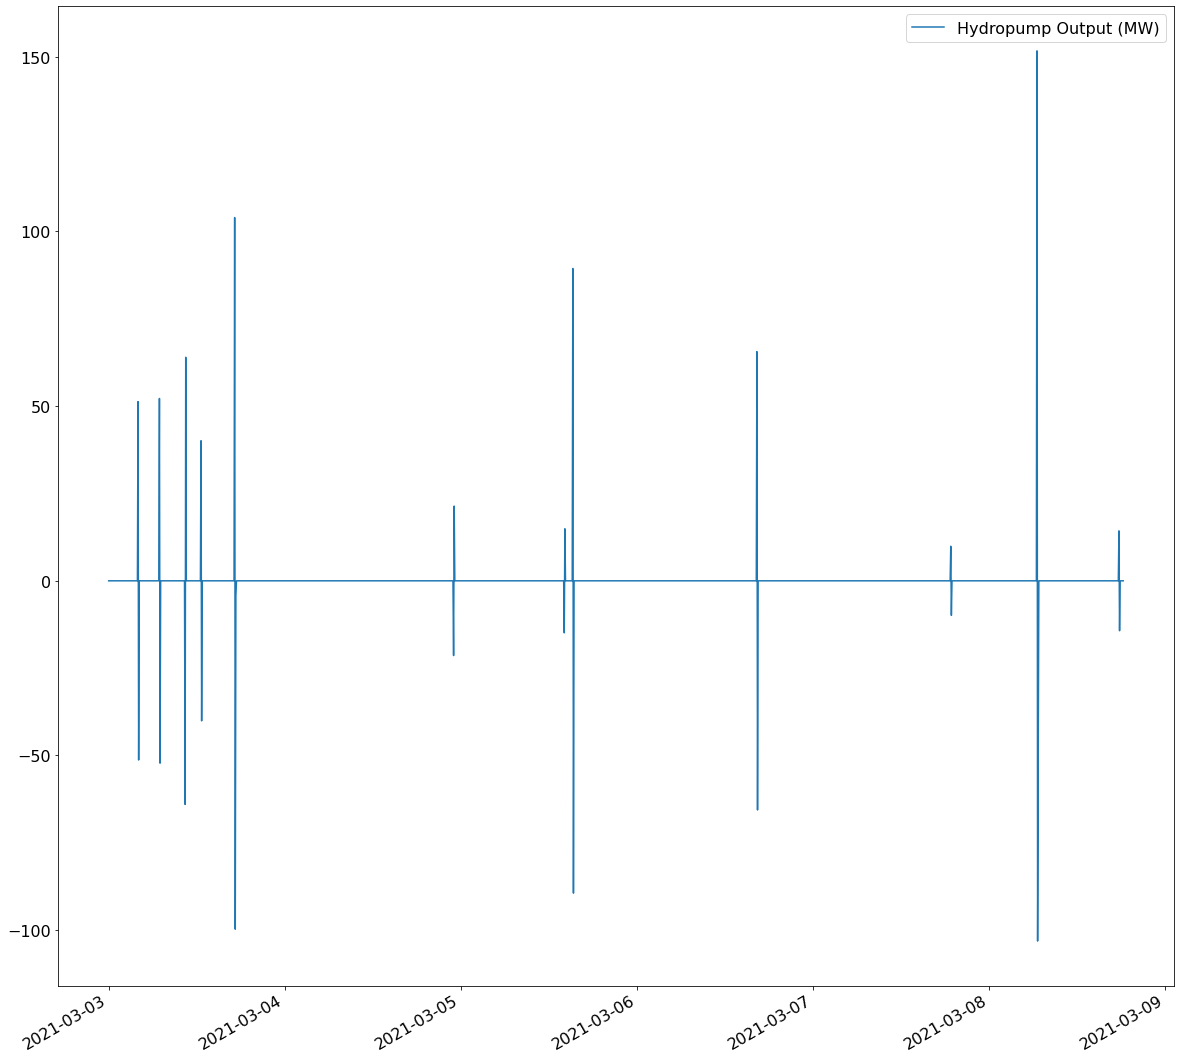

In [20]:

ONTARIO_HOURLY_PATH = 'data/ontario_5min.csv'
START_TIMESTAMP = '2021-03-03T00:00:00'

MAX_CAPACITY = 19166.9
CAPACITY_ACCEL_PER_5_MIN = REACTOR_SPIN_UP_DOWN_RATE_PERCENT_PER_MIN * 5 * MAX_CAPACITY

ontario_hourly_usage = []
started_at = arrow.get(START_TIMESTAMP)

with open(ONTARIO_HOURLY_PATH) as ontario_hourly_file:
    reader = csv.reader(ontario_hourly_file)
    curr_time = started_at
    first_row = next(reader)
    prev_grid_demand = float(first_row[0])
    nuclear_supply_mwh = prev_grid_demand
    max_delta = 0
    total_hydropump_usage = 0
    for row in reader:
        grid_demand_mwh = float(row[0])
        # We want to get the pumped hydro back to break-even, if possible
        desired_output = grid_demand_mwh + total_hydropump_usage
        desired_adjustment = desired_output - nuclear_supply_mwh
        # You can't adjust up or down faster than the
        # CAPACITY_ACCEL_PER_5_MIN
        actual_adjustment = max(
            -1 * CAPACITY_ACCEL_PER_5_MIN, 
            min(desired_adjustment, CAPACITY_ACCEL_PER_5_MIN)
        )
        nuclear_supply_mwh += actual_adjustment
        # If you couldn't adjust fast enough, use the pumped hydro
        hydropump_supply_mwh = grid_demand_mwh - nuclear_supply_mwh
        total_hydropump_usage += hydropump_supply_mwh
        datum = {
            "time":  pd.to_datetime(curr_time.isoformat()), 
            "grid_demand_mwh": grid_demand_mwh, 
            'nuclear_supply_mwh': nuclear_supply_mwh, 
            'hydropump_supply_mwh': hydropump_supply_mwh,
            "delta": ((prev_grid_demand / grid_demand_mwh) - 1)/5
        }
        
        ontario_hourly_usage.append(datum)
        curr_time = curr_time.shift(minutes=+5)
        prev_grid_demand = grid_demand_mwh
        
df = pd.DataFrame.from_dict(ontario_hourly_usage)

fig, ax = plt.subplots()
ax.plot('time', 'hydropump_supply_mwh', data=df, label='Hydropump Output (MW)')
ax.legend()

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
plt.show()


In [21]:

df.min()

time                    2021-03-03 00:00:00+00:00
grid_demand_mwh                           13743.7
nuclear_supply_mwh                        13743.7
hydropump_supply_mwh                     -103.114
delta                                 -0.00512402
dtype: object

In [22]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660 entries, 0 to 1659
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   time                  1660 non-null   datetime64[ns, UTC]
 1   grid_demand_mwh       1660 non-null   float64            
 2   nuclear_supply_mwh    1660 non-null   float64            
 3   hydropump_supply_mwh  1660 non-null   float64            
 4   delta                 1660 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 65.0 KB


In [23]:

df.max()

time                    2021-03-08 18:15:00+00:00
grid_demand_mwh                           19166.9
nuclear_supply_mwh                        19166.9
hydropump_supply_mwh                      151.693
delta                                  0.00409132
dtype: object

In [24]:
sum(df['hydropump_supply_mwh'])

0.0

<Figure size 1440x1440 with 0 Axes>

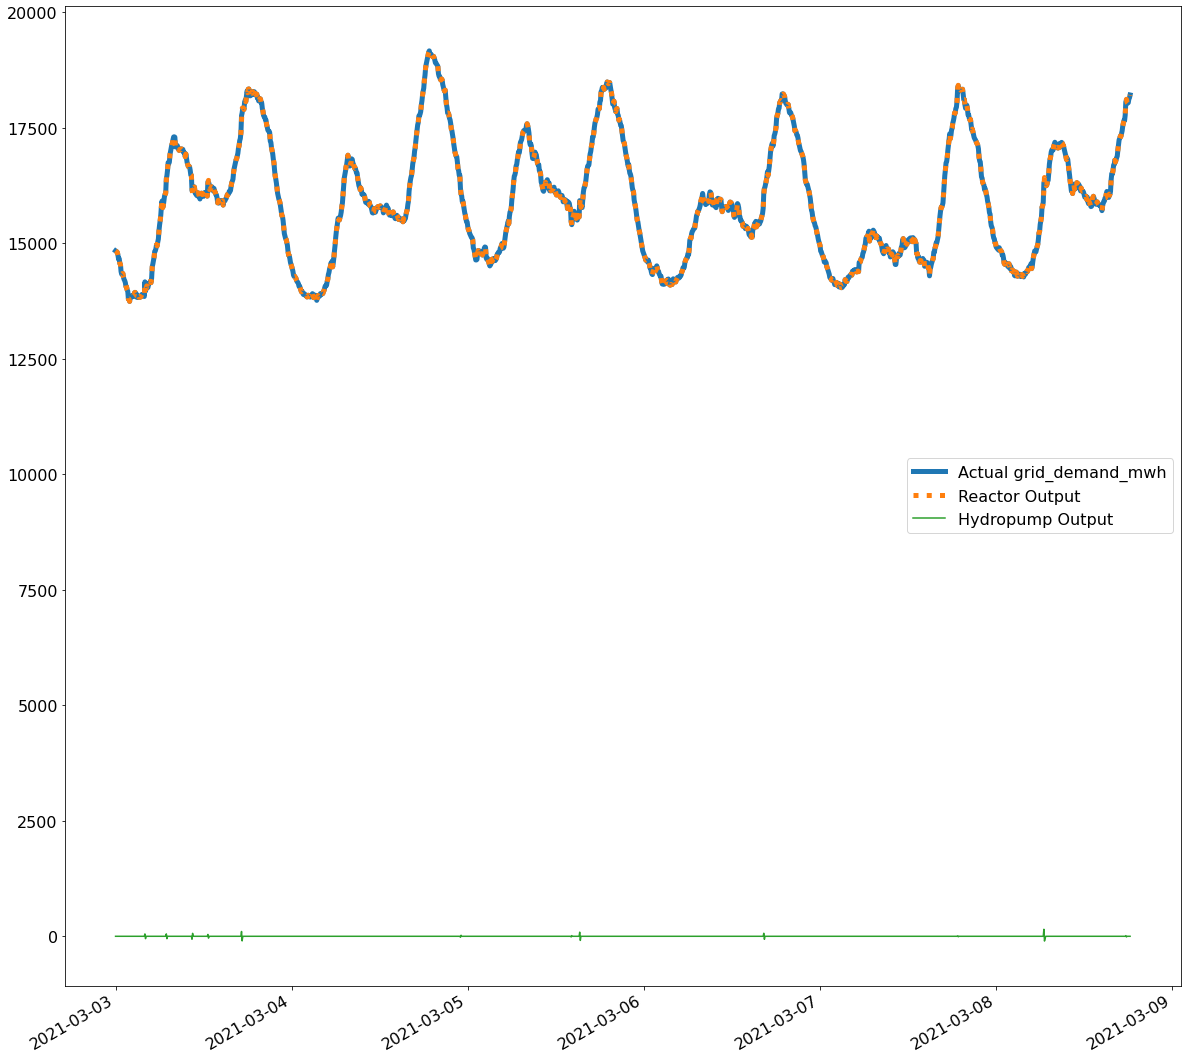

In [39]:
plt.clf()
fig, ax = plt.subplots()
ax.plot('time', 'grid_demand_mwh', data=df, label='Actual grid_demand_mwh', linestyle='-', linewidth=5)
ax.plot('time', 'nuclear_supply_mwh', data=df, label='Reactor Output', linestyle=':', linewidth=5)
ax.plot('time', 'hydropump_supply_mwh', data=df, label='Hydropump Output')
ax.legend()

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
plt.show()



<Figure size 1440x1440 with 0 Axes>

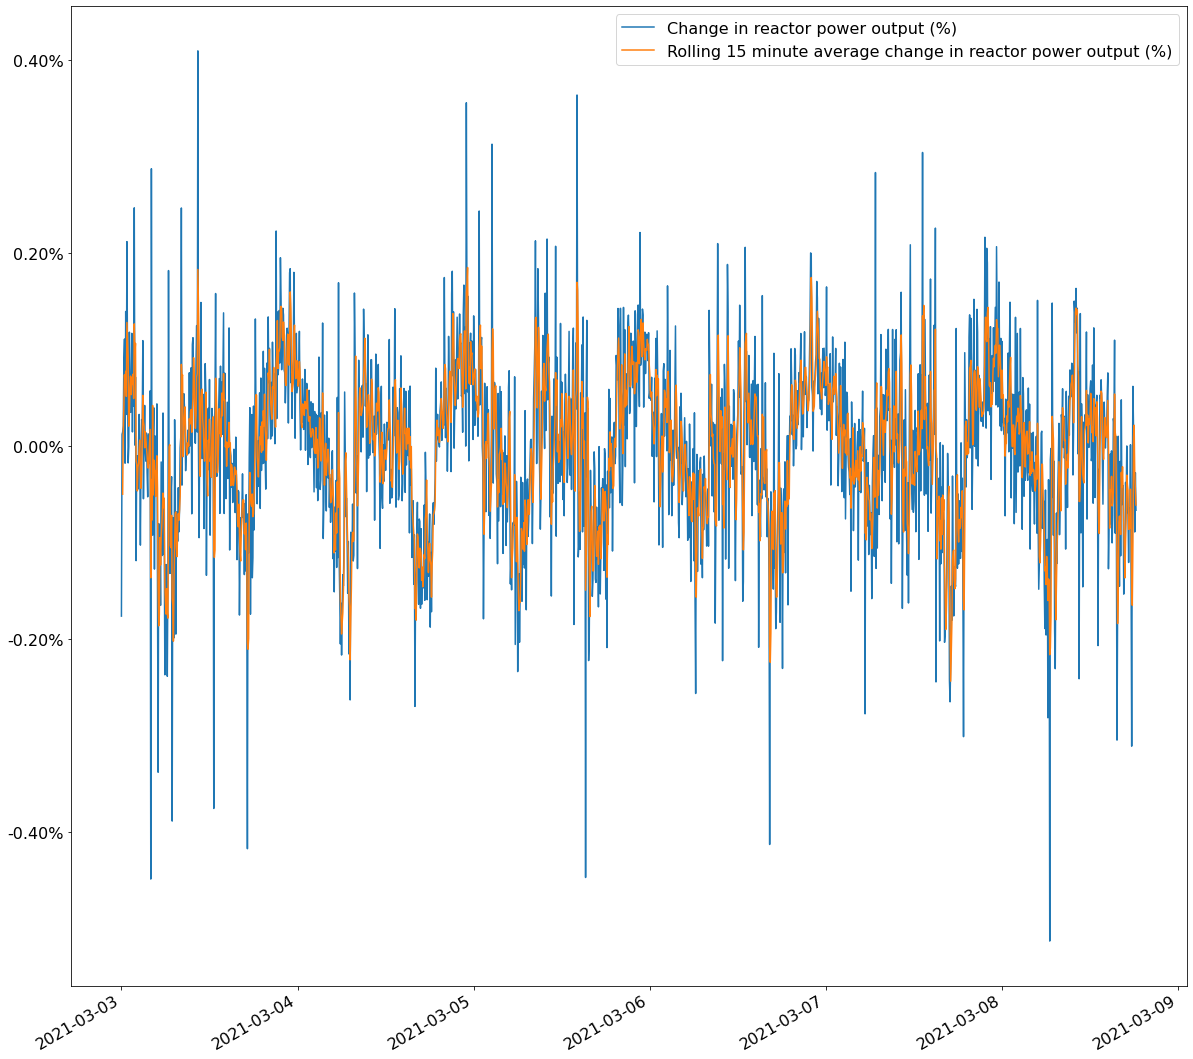

In [50]:
plt.clf()
fig, ax = plt.subplots()
df['rolling_delta'] = df['delta'].rolling(3).mean()
ax.plot('time', 'delta', data=df, label='Change in reactor power output (%)')
ax.plot('time', 'rolling_delta', data=df, label='Rolling 15 minute average change in reactor power output (%)')
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.legend()

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
plt.show()


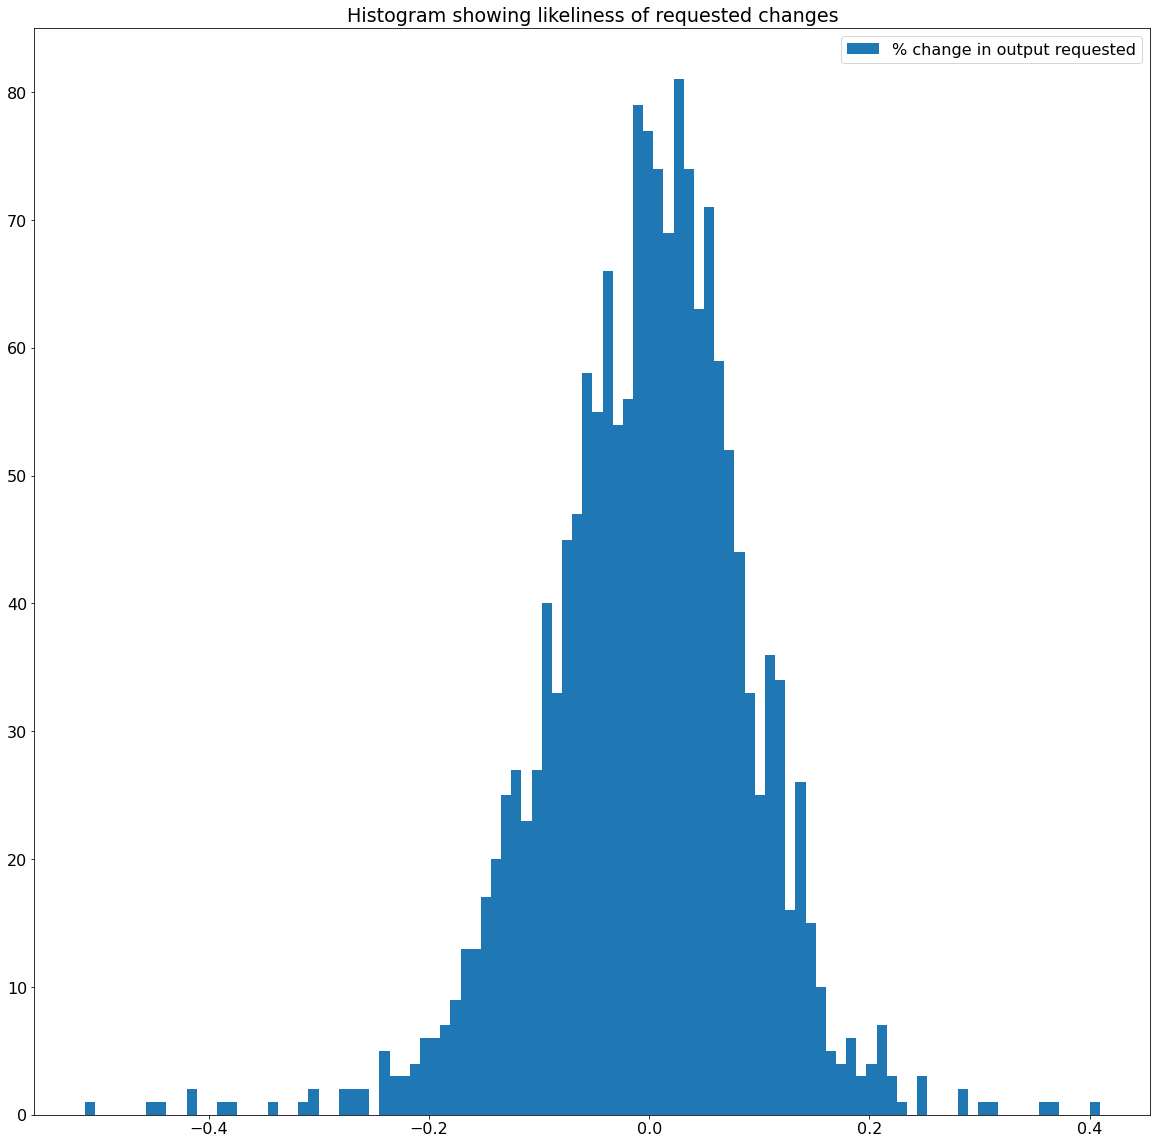

In [30]:
plt.clf()
plt.hist(df['delta'] * 100, 100, label="% change in output requested")
plt.legend()
plt.title('Histogram showing likeliness of requested changes')
plt.show()

In [31]:
in_bounds = 0
out_of_bounds = 0
for delta in df['delta']:
    if abs(delta) > REACTOR_SPIN_UP_DOWN_RATE_PERCENT_PER_MIN:
        out_of_bounds += 1
    else:
        in_bounds += 1
print(f"""
  Within load-follow bounds ({100 * in_bounds / (in_bounds + out_of_bounds)}%):
    {in_bounds} / {in_bounds + out_of_bounds}
  Peaker plant required ({100 * out_of_bounds / (in_bounds + out_of_bounds)}%):
    {out_of_bounds} / {in_bounds + out_of_bounds}
""")



  Within load-follow bounds (98.855421686747%):
    1641 / 1660
  Peaker plant required (1.144578313253012%):
    19 / 1660

